# Importación de librerias

In [ ]:
pip install meteostat

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from meteostat import Daily,Point

In [ ]:
#Descargamos desde drive el dataset
!gdown 1ywvc4bNipqJb5lSgp6GY6VELAnSXWMVT

Downloading...
From: https://drive.google.com/uc?id=1ywvc4bNipqJb5lSgp6GY6VELAnSXWMVT
To: /content/uber_fares.csv
100% 23.5M/23.5M [00:00<00:00, 68.5MB/s]


In [ ]:
#Carga datos de dataset en dataframe
file_path = 'uber_fares.csv'

df = pd.read_csv(file_path)

In [ ]:
#Visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [ ]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Comportamiento y Rango de Variación:
*   Tarifas: Alta variabilidad con algunos valores extremos.
*   Ubicaciones: Amplia dispersión en longitudes y latitudes, lo que puede indicar errores o un área geográfica extensa.
*   Pasajeros: La mayoría de los viajes son para 1-2 pasajeros, pero hay casos atípicos con números muy altos.



In [ ]:
#Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [ ]:
#Información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


#Acondicionamiento del dataset

In [ ]:
#Cambio el Dtype de la columna pickup_datetime a DateTime.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
#Cantidad de valores nulos en el Dataframe. No hay valores nulos de la variable target.
nan_count = df.isna().sum()
print(nan_count)

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [ ]:
df.dropna(inplace=True)

Antes de comenzar el analisis descriptivo vamos a crear la columna distancia_km para poder hacer un analisis mas completo ya que las variables de longitud y latitud crudas no nos dicen nada


Los límites geográficos aproximados de la ciudad de Nueva York son:

Latitud:

*   Mínima: aproximadamente 40.5
*   Máxima: aproximadamente 45.0

Longitud:
*   Mínima: aproximadamente -74.05
*   Máxima: aproximadamente -73.70

In [ ]:
num_filas_inicial = df.shape[0]

# Definir los límites geográficos aproximados de Nueva York
lat_min, lat_max = 39.5, 41.5
lon_min, lon_max = -75.0, -73.0

# Filtrar el DataFrame para incluir solo los datos dentro de los límites de Nueva York
df = df[(df["pickup_latitude"].between(lat_min, lat_max)) &
        (df["dropoff_latitude"].between(lat_min, lat_max)) &
        (df["pickup_longitude"].between(lon_min, lon_max)) &
        (df["dropoff_longitude"].between(lon_min, lon_max))]

num_filas_final = df.shape[0]
num_filas_eliminadas = num_filas_inicial - num_filas_final
porcentaje_eliminadas = (num_filas_eliminadas / num_filas_inicial) * 100 if num_filas_inicial > 0 else 0
print(f"Número de filas eliminadas: {num_filas_eliminadas}, Porcentaje del total: {porcentaje_eliminadas:.2f}%")

Número de filas eliminadas: 4169, Porcentaje del total: 2.08%


Pasamos los datos de pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude a km, utilizando la distancia de manhattan

In [ ]:
#Calculo de las distancias entre los puntos de pickup y dropoff
def distancia_manhattan_km(row):
    """
    Calcula la distancia de Manhattan en kilómetros entre los puntos de pickup y dropoff.
    """
    km_por_grado_lat = 111  # 1° de latitud ≈ 111 km
    km_por_grado_lon = 85   # 1° de longitud ≈ 85 km (en NYC)

    delta_lon_km = abs(row['dropoff_longitude'] - row['pickup_longitude']) * km_por_grado_lon
    delta_lat_km = abs(row['dropoff_latitude'] - row['pickup_latitude']) * km_por_grado_lat

    return delta_lon_km + delta_lat_km

# Aplicar la función a cada fila
df['distancia_manhattan_km'] = df.apply(distancia_manhattan_km, axis=1)

In [ ]:
# Contar cuántos valores no válidos hay
num_invalidos_distancia = df[df["distancia_manhattan_km"] <= 0].shape[0]
num_invalidos_fare = df[df["fare_amount"] <= 0].shape[0]

print(f"Número de distancias no válidas: {num_invalidos_distancia}")
print(f"Número de tarifas no válidas: {num_invalidos_fare}")

df_invalid = df[df["distancia_manhattan_km"] <= 0]
df_invalid

Número de distancias no válidas: 2040
Número de tarifas no válidas: 19


,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_manhattan_km
5,44470845,2011-02-12 02:27:09.0000006,4.90,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.0
48,22405517,2013-01-03 22:24:41.0000002,56.80,2013-01-03 22:24:41+00:00,-73.993498,40.764686,-73.993498,40.764686,1,0.0
84,25485719,2009-08-07 10:43:07.0000001,49.57,2009-08-07 10:43:07+00:00,-73.975058,40.788820,-73.975058,40.788820,1,0.0
166,54642873,2014-01-22 21:01:18.0000004,4.50,2014-01-22 21:01:18+00:00,-73.992937,40.757780,-73.992937,40.757780,1,0.0
361,11876316,2009-08-24 17:25:00.00000056,10.10,2009-08-24 17:25:00+00:00,-73.928705,40.753475,-73.928705,40.753475,1,0.0
...,...,...,...,...,...,...,...,...,...,...
199448,42657809,2010-07-24 21:16:00.00000062,5.70,2010-07-24 21:16:00+00:00,-73.924907,40.745833,-73.924907,40.745833,3,0.0
199612,11772885,2013-02-17 11:27:00.00000040,4.50,2013-02-17 11:27:00+00:00,-73.969717,40.765832,-73.969717,40.765832,3,0.0
199647,32051586,2009-06-07 02:07:26.0000001,2.50,2009-06-07 02:07:26+00:00,-73.956623,40.771633,-73.956623,40.771633,1,0.0
199917,45368488,2013-06-24 22:17:43.0000002,4.50,2013-06-24 22:17:43+00:00,-73.793768,40.656939,-73.793768,40.656939,1,0.0


eliminamos los valores de "fare_amount" no validos (>0) ya que son 19 y no representan un gran porcentaje del total

In [ ]:
df = df[df["fare_amount"] > 0]

In [ ]:
import holidays

us_holidays = holidays.US()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Crear una nueva columna 'is_holiday' que indica si el día del viaje es feriado (0:no o 1:si)
df['is_holiday'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Contar cuántos viajes ocurrieron en días feriados y cuántos no
holiday_counts = df['is_holiday'].value_counts()

print(holiday_counts)

is_holiday
0    191373
1      4438
Name: count, dtype: int64


In [ ]:
def agregar_clima(df):
    df['date'] = pd.to_datetime(df['date'])
    df['fecha'] = df['date'].dt.floor('D')

    start = df['fecha'].min()
    end = df['fecha'].max()


    # 🔁 USAMOS API en vez de código de estación: usamos coordenadas de NYC
    nyc = Point(40.7128, -74.0060)
    clima_data = Daily(nyc, start, end)
    clima_data = clima_data.fetch().reset_index()

    if clima_data.empty:
        print("⚠️ No se descargaron df de clima.")
        return df

    clima_data['fecha'] = pd.to_datetime(clima_data['time']).dt.floor('D')
    clima_data['llovia'] = clima_data['prcp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
    clima_data = clima_data.rename(columns={'tavg': 'temp_promedio'})
    clima_data = clima_data[['fecha', 'temp_promedio', 'llovia']]


    df = df.sort_values('fecha')
    clima_data = clima_data.sort_values('fecha')

    df = pd.merge_asof(df, clima_data, on='fecha')

    return df

In [ ]:
df = agregar_clima(df)

Desglosamos la fecha "pickup_datetime"

In [ ]:
# Extraer características numéricas de la fecha
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Eliminar la columna original pickup_datetime
df.drop(columns=['pickup_datetime'], inplace=True)

Para no pasarle al modelo 24 horas, lo dividimos en 3 rangos de 8 horas

In [ ]:
#Dividir en 3 rangos horarios
condiciones = [
    (df["hour"] >= 6) & (df["hour"] < 12),   # Mañana
    (df["hour"] >= 12) & (df["hour"] < 20),  # Tarde
    (df["hour"] >= 20) | (df["hour"] < 6)    # Noche
]

valores = [0, 1, 2]

df["momento_dia"] = np.select(condiciones, valores)

#Dividir los meses en 4 estaciones
condiciones = [
    (df["month"] == 12) | (df["month"] == 1) | (df["month"] == 2),      # Verano
    (df["month"] >= 3) & (df["month"] <= 5),                            # Otoño
    (df["month"] >= 6) & (df["month"] <= 8),                            # Invierno
    (df["month"] >= 9) & (df["month"] <= 11)                            # Primavera
]

valores = [0, 1, 2, 3]

df["estacion"] = np.select(condiciones, valores)

In [ ]:
df.drop(columns=['key','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','date','fecha'], inplace=True)
df.drop(columns=['month','day_of_week','hour'], inplace=True)

In [ ]:
df

,fare_amount,passenger_count,distancia_manhattan_km,is_holiday,temp_promedio,llovia,year,is_weekend,momento_dia,estacion
0,5.7,2,2.063902,1,-5.8,0,2009,0,2,0
1,6.1,1,3.433134,1,-5.8,0,2009,0,2,0
2,9.3,1,6.475122,1,-5.8,0,2009,0,1,0
3,5.3,3,1.119725,1,-5.8,0,2009,0,2,0
4,7.7,2,4.139123,1,-5.8,0,2009,0,1,0
...,...,...,...,...,...,...,...,...,...,...
195806,10.5,4,2.641003,0,23.4,0,2015,0,0,2
195807,13.5,1,6.118958,0,23.4,0,2015,0,1,2
195808,6.5,1,0.942375,0,23.4,0,2015,0,0,2
195809,11.0,1,2.958317,0,23.4,0,2015,0,1,2


los pasajeros pueden ir de 1 a 6

In [ ]:
df_sd = df[df["passenger_count"]>0]
df_sd = df[df["passenger_count"]<7]

print(df_sd["passenger_count"].value_counts())

passenger_count
1    135504
2     28839
5     13720
3      8696
6      4184
4      4181
0       686
Name: count, dtype: int64


#Visualizacion de datos

Text(0, 0.5, 'Frecuencia')

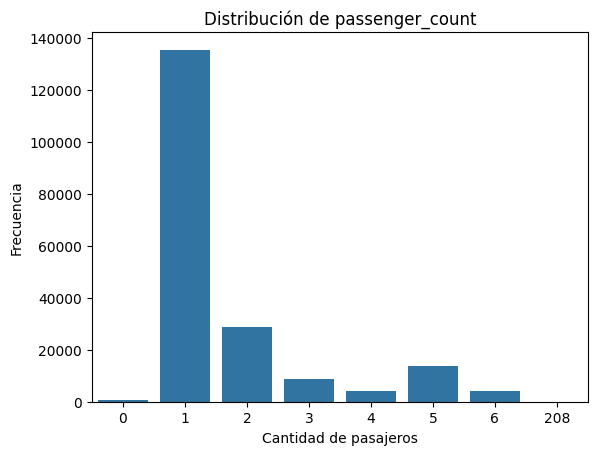

In [ ]:
sns.barplot(x=df['passenger_count'].value_counts().index, y=df['passenger_count'].value_counts())
plt.title("Distribución de passenger_count")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")

In [ ]:
df

,fare_amount,passenger_count,distancia_manhattan_km,is_holiday,temp_promedio,llovia,year,is_weekend,momento_dia,estacion
0,5.7,2,2.063902,1,-5.8,0,2009,0,2,0
1,6.1,1,3.433134,1,-5.8,0,2009,0,2,0
2,9.3,1,6.475122,1,-5.8,0,2009,0,1,0
3,5.3,3,1.119725,1,-5.8,0,2009,0,2,0
4,7.7,2,4.139123,1,-5.8,0,2009,0,1,0
...,...,...,...,...,...,...,...,...,...,...
195806,10.5,4,2.641003,0,23.4,0,2015,0,0,2
195807,13.5,1,6.118958,0,23.4,0,2015,0,1,2
195808,6.5,1,0.942375,0,23.4,0,2015,0,0,2
195809,11.0,1,2.958317,0,23.4,0,2015,0,1,2


Text(0, 0.5, 'Frecuencia')

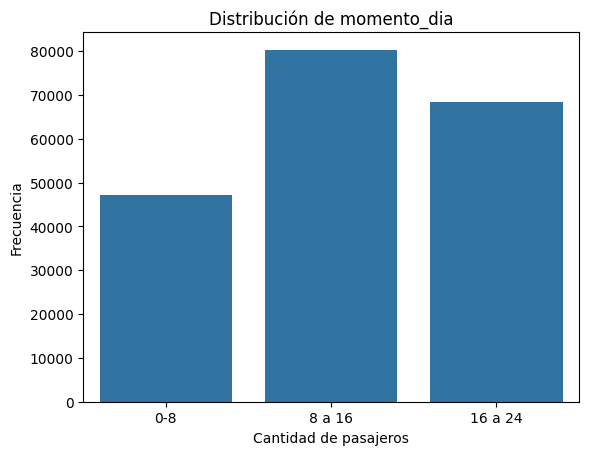

In [ ]:
sns.barplot(x=df['momento_dia'].value_counts().index, y=df['momento_dia'].value_counts())
etiquetas = ['0-8', '8 a 16', '16 a 24']
plt.title("Distribución de momento_dia")
plt.xlabel("Cantidad de pasajeros")
plt.xticks(ticks=range(len(etiquetas)), labels=etiquetas)
plt.ylabel("Frecuencia")

Text(0, 0.5, 'Frecuencia')

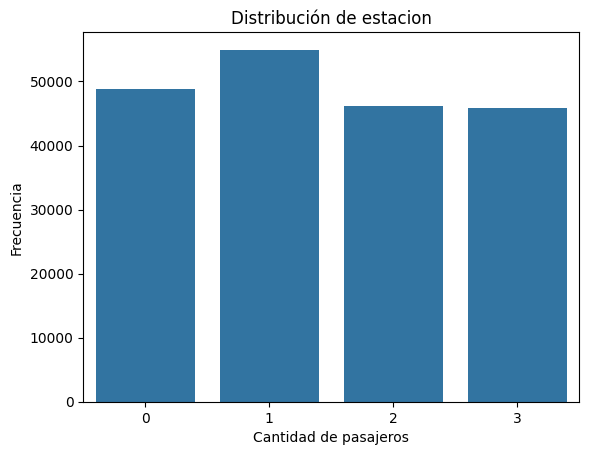

In [ ]:
sns.barplot(x=df['estacion'].value_counts().index, y=df['estacion'].value_counts())
plt.title("Distribución de estacion")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")

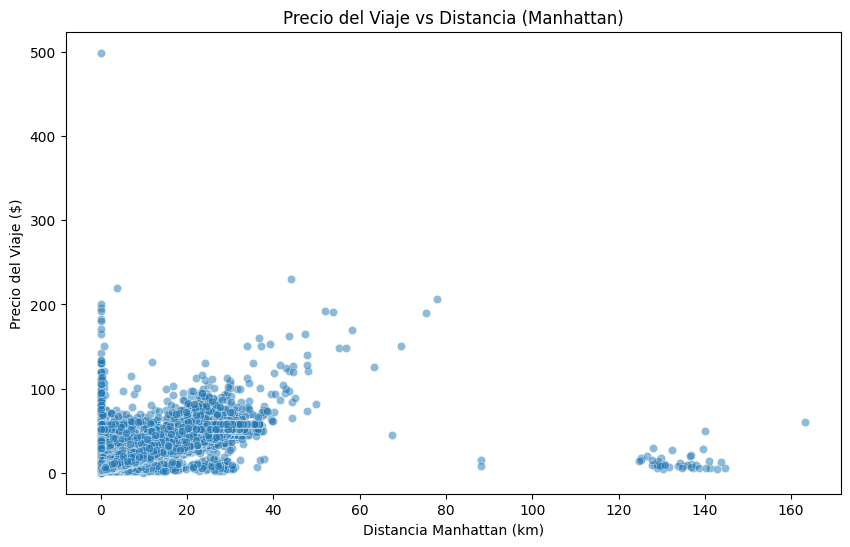

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distancia_manhattan_km', y='fare_amount', alpha=0.5)

plt.title('Precio del Viaje vs Distancia (Manhattan)')
plt.xlabel('Distancia Manhattan (km)')
plt.ylabel('Precio del Viaje ($)')

plt.show()

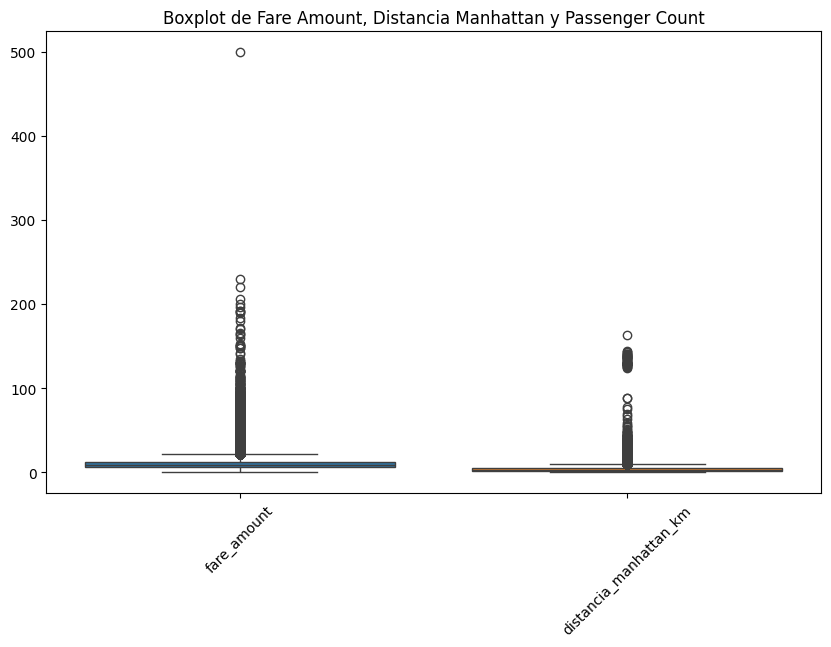

In [ ]:
columns_to_plot = ['fare_amount', 'distancia_manhattan_km']

# Crear un boxplot para las columnas seleccionadas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[columns_to_plot])
plt.xticks(rotation=45)
plt.title('Boxplot de Fare Amount, Distancia Manhattan y Passenger Count')
plt.show()

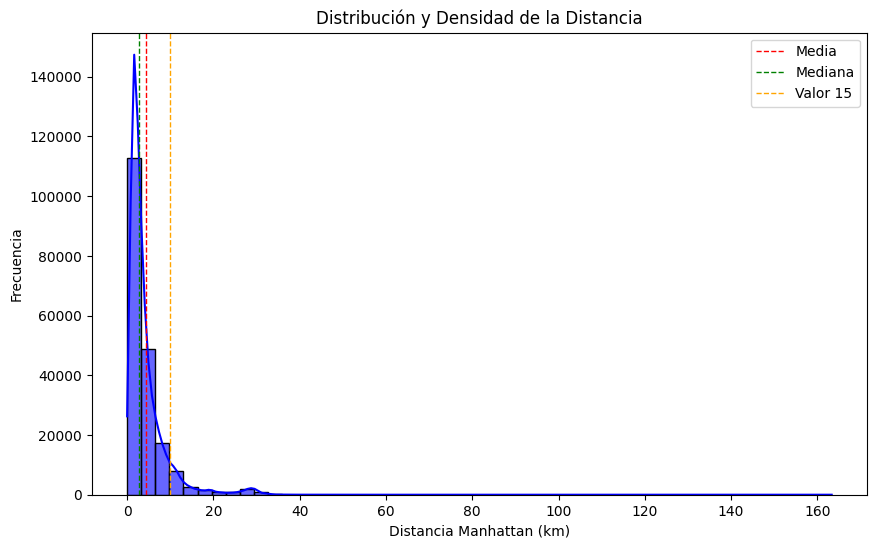

Media: 4.315978366519089
Mediana: 2.7752090000006575
Desviación Estándar: 5.155032491627737


In [ ]:

# Histograma y gráfico de densidad
plt.figure(figsize=(10, 6))
sns.histplot(df['distancia_manhattan_km'], bins=50, kde=True, color='blue', alpha=0.6)
plt.axvline(df['distancia_manhattan_km'].mean(), color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(df['distancia_manhattan_km'].median(), color='green', linestyle='dashed', linewidth=1, label='Mediana')
plt.axvline(10, color='orange', linestyle='dashed', linewidth=1, label='Valor 15')
plt.xlabel('Distancia Manhattan (km)')
plt.ylabel('Frecuencia')
plt.title('Distribución y Densidad de la Distancia')
plt.legend()
plt.show()

# Calcular estadísticas descriptivas
media = df['distancia_manhattan_km'].mean()
mediana = df['distancia_manhattan_km'].median()
desviacion_estandar = df['distancia_manhattan_km'].std()

print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Desviación Estándar: {desviacion_estandar}")

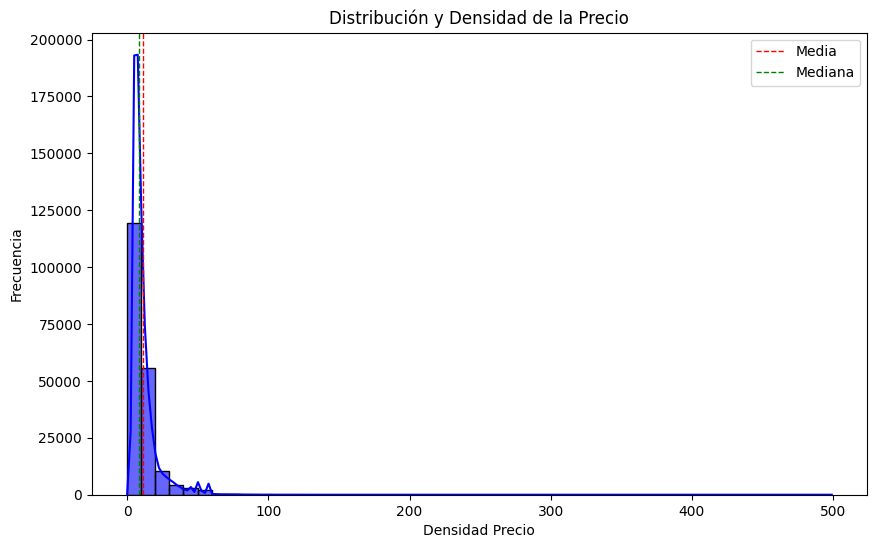

Media: 11.343126126724238
Mediana: 8.5
Desviación Estándar: 9.793645573631162


In [ ]:

# Histograma y gráfico de densidad
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True, color='blue', alpha=0.6)
plt.axvline(df['fare_amount'].mean(), color='red', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(df['fare_amount'].median(), color='green', linestyle='dashed', linewidth=1, label='Mediana')
plt.xlabel('Densidad Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución y Densidad de la Precio')
plt.legend()
plt.show()

# Calcular estadísticas descriptivas
media = df['fare_amount'].mean()
mediana = df['fare_amount'].median()
desviacion_estandar = df['fare_amount'].std()

print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Desviación Estándar: {desviacion_estandar}")

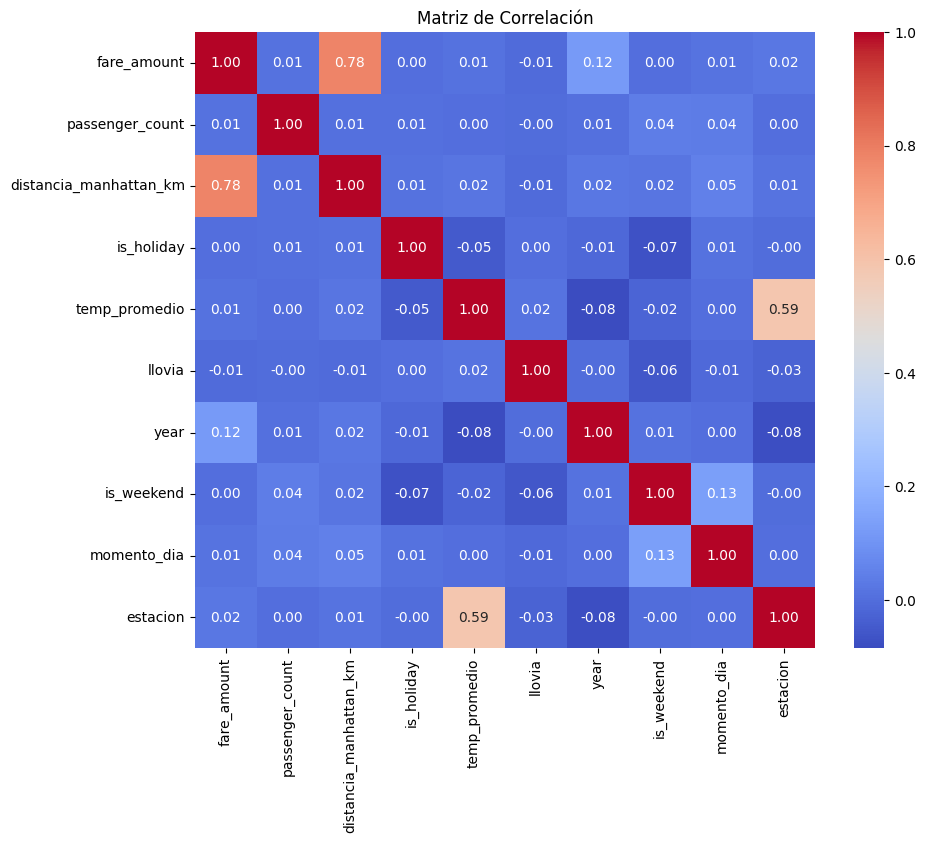

In [ ]:
# Calcular la matriz de correlación
matriz_correlacion = df.corr()


# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#Dividir en conjunto de entrenamiento y test

dividimos unicamente en train y test para poder imputar los dos subconjuntos por separado y no tener que separar la variable objetivo

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.describe()

,fare_amount,passenger_count,distancia_manhattan_km,is_holiday,temp_promedio,llovia,year,is_weekend,momento_dia,estacion
count,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000,156648.000000
mean,11.325751,1.684726,4.312983,0.022758,12.971684,0.322532,2011.736932,0.284447,1.109207,1.458148
std,9.724002,1.406606,5.182662,0.149132,9.868261,0.467447,1.860409,0.451152,0.760745,1.103103
min,0.010000,0.000000,0.000000,0.000000,-12.800000,0.000000,2009.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,1.605013,0.000000,4.900000,0.000000,2010.000000,0.000000,1.000000,1.000000
50%,8.500000,1.000000,2.774442,0.000000,13.500000,0.000000,2012.000000,0.000000,1.000000,1.000000
75%,12.500000,2.000000,5.039470,0.000000,21.500000,1.000000,2013.000000,1.000000,2.000000,2.000000
max,230.000000,208.000000,144.647455,1.000000,35.800000,1.000000,2015.000000,1.000000,2.000000,3.000000


In [ ]:
#Ver si hay valores nulos en el conjunto de entrenamiento X_train
print(train_df.isna().sum())

fare_amount               0
passenger_count           0
distancia_manhattan_km    0
is_holiday                0
temp_promedio             0
llovia                    0
year                      0
is_weekend                0
momento_dia               0
estacion                  0
dtype: int64


In [ ]:
test_df.describe()

,fare_amount,passenger_count,distancia_manhattan_km,is_holiday,temp_promedio,llovia,year,is_weekend,momento_dia,estacion
count,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000,39163.000000
mean,11.412625,1.685188,4.327960,0.022291,12.932778,0.325205,2011.747517,0.279882,1.102520,1.439343
std,10.067224,1.309393,5.043051,0.147632,9.852721,0.468457,1.855041,0.448947,0.758746,1.100564
min,0.010000,0.000000,0.000000,0.000000,-12.800000,0.000000,2009.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,1.611954,0.000000,4.800000,0.000000,2010.000000,0.000000,1.000000,0.000000
50%,8.500000,1.000000,2.779354,0.000000,13.400000,0.000000,2012.000000,0.000000,1.000000,1.000000
75%,12.500000,2.000000,5.100329,0.000000,21.400000,1.000000,2013.000000,1.000000,2.000000,2.000000
max,499.000000,6.000000,163.314311,1.000000,35.800000,1.000000,2015.000000,1.000000,2.000000,3.000000


In [ ]:
#Ver si hay valores nulos en el conjunto de entrenamiento X_test
print(test_df.isna().sum())

fare_amount               0
passenger_count           0
distancia_manhattan_km    0
is_holiday                0
temp_promedio             0
llovia                    0
year                      0
is_weekend                0
momento_dia               0
estacion                  0
dtype: int64


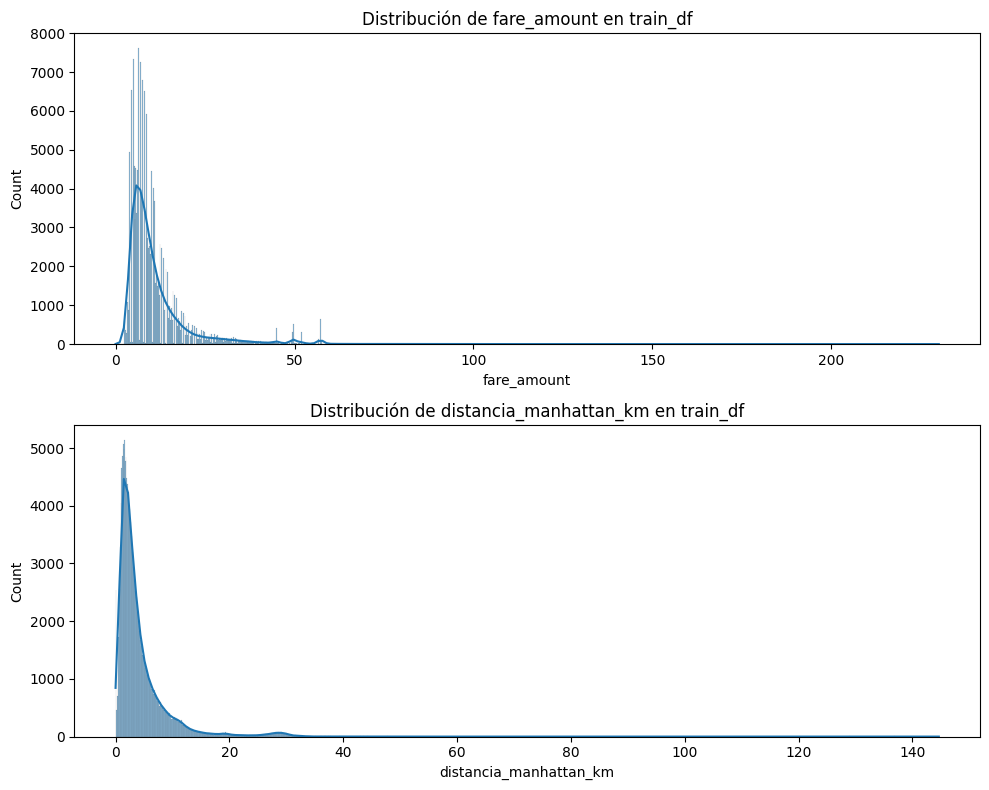

In [ ]:
plt.figure(figsize=(10, 8))

# Histograma para 'fare_amount' en train_df
plt.subplot(2, 1, 1)
sns.histplot(train_df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en train_df")

# Histograma para 'distancia_manhattan_km' en train_df
plt.subplot(2, 1, 2)
sns.histplot(train_df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en train_df")

plt.tight_layout()
plt.show()

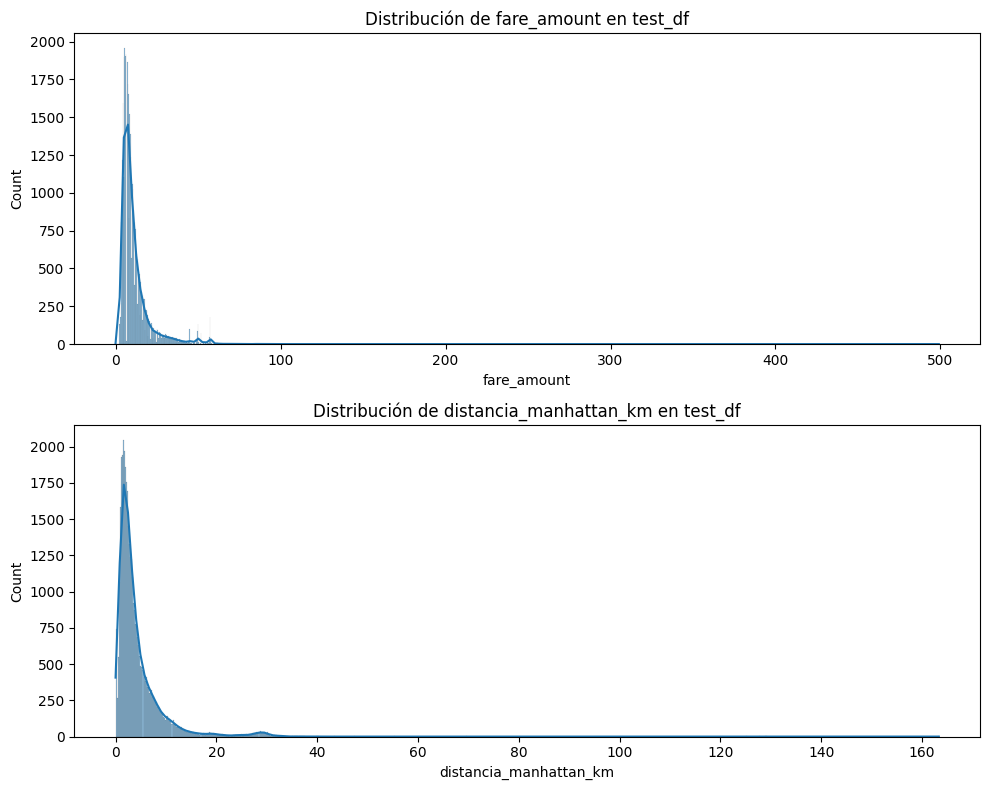

In [ ]:
plt.figure(figsize=(10, 8))

# Histograma para 'fare_amount' en test_df
plt.subplot(2, 1, 1)
sns.histplot(test_df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en test_df")

# Histograma para 'distancia_manhattan_km' en test_df
plt.subplot(2, 1, 2)
sns.histplot(test_df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en test_df")

plt.tight_layout()
plt.show()

#Imputacion de los outliers detectados:

### Imputacion Passanger_count

imputamos los valores de "passanger_count" que sean menores a 1 y mayores a 6

Elegimos imputar los valores fuera del rango en 'passenger_count' utilizando la mediana porque este enfoque permite mantener la tendencia central de los datos y minimizar la influencia de valores atípicos. Dado que el número de pasajeros en uber varía entre 1 y 6, los valores fuera de este rango son considerados erróneos. Al utilizar la mediana, aseguramos que la imputación sea representativa y robusta, lo que mejora la calidad del conjunto de datos y la efectividad de los modelos predictivos sin introducir sesgos significativos.

In [ ]:
# Contar valores fuera del rango en 'passenger_count' antes de la imputación
out_of_range_train = train_df[(train_df['passenger_count'] < 1) | (train_df['passenger_count'] > 6)].shape[0]
out_of_range_test = test_df[(test_df['passenger_count'] < 1) | (test_df['passenger_count'] > 6)].shape[0]

# Calcular la mediana de 'passenger_count' para train_df
mediana_passenger_count_train = train_df['passenger_count'].median()

# Imputar valores fuera del rango en 'passenger_count' en train_df
train_df.loc[(train_df['passenger_count'] < 1) | (train_df['passenger_count'] > 6), 'passenger_count'] = mediana_passenger_count_train

# Calcular la mediana de 'passenger_count' para test_df
mediana_passenger_count_test = test_df['passenger_count'].median()

# Imputar valores fuera del rango en 'passenger_count' en test_df
test_df.loc[(test_df['passenger_count'] < 1) | (test_df['passenger_count'] > 6), 'passenger_count'] = mediana_passenger_count_test

print(f"Valores fuera del rango en 'passenger_count' en test_df: {out_of_range_test}")

Valores fuera del rango en 'passenger_count' en test_df: 143


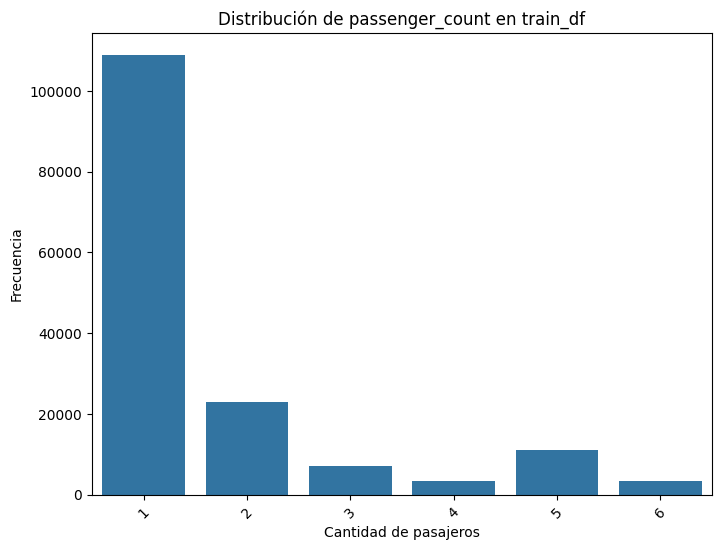

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=train_df['passenger_count'].value_counts().index,
            y=train_df['passenger_count'].value_counts().values)
plt.title("Distribución de passenger_count en train_df")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x si es necesario
plt.show()

### Imputacion Fare_amount

Decidimos imputar los valores de fare_amount que son considerados outliers utilizando la mediana general. Este enfoque nos permite manejar las tarifas atípicas de manera consistente, ya que la mediana es menos sensible a los valores extremos y proporciona una estimación central robusta. Al utilizar la mediana, aseguramos que los valores imputados reflejen una tarifa típica, minimizando el impacto de los outliers en el análisis y manteniendo la integridad de los datos.

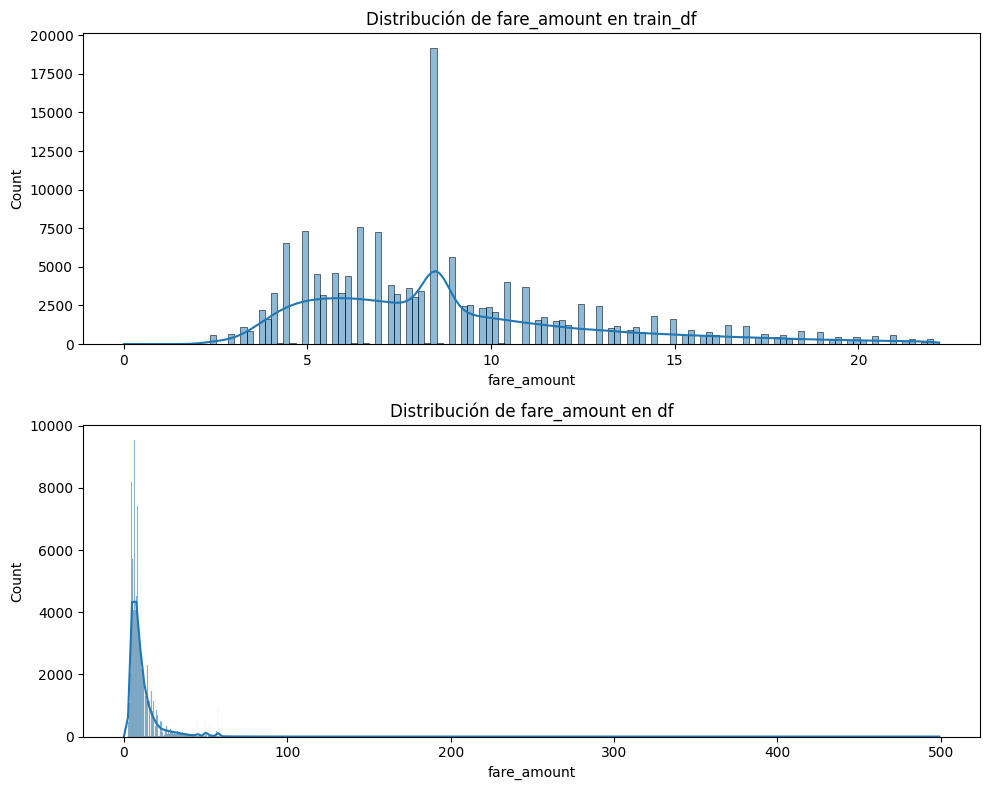

In [ ]:
# Calcular el IQR para identificar outliers en train_df
Q1_train = train_df['fare_amount'].quantile(0.25)
Q3_train = train_df['fare_amount'].quantile(0.75)
IQR_train = Q3_train - Q1_train
lower_bound_train = 0  # Establecer el límite inferior en 0
upper_bound_train = Q3_train + 1.5 * IQR_train

# Calcular la mediana general de 'fare_amount' en train_df
mediana_fare_train = train_df['fare_amount'].median()

# Función para imputar outliers
def imputar_outliers_train(row):
    if row['fare_amount'] < lower_bound_train or row['fare_amount'] > upper_bound_train:
        return mediana_fare_train
    return row['fare_amount']

# Aplicar imputación de outliers en train_df
train_df['fare_amount'] = train_df.apply(imputar_outliers_train, axis=1)

# Visualizar la distribución después de la imputación
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.histplot(train_df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en train_df")

plt.subplot(2, 1, 2)
sns.histplot(df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en df")

plt.tight_layout()
plt.show()

In [ ]:
# Calcular el IQR para identificar outliers en train_df
Q1_train = train_df['fare_amount'].quantile(0.25)
Q3_train = train_df['fare_amount'].quantile(0.75)
IQR_train = Q3_train - Q1_train
lower_bound_test = 0  # Establecer el límite inferior en 0
upper_bound_test = Q3_train + 1.5 * IQR_train

# Calcular la mediana general de 'fare_amount' en test_df
mediana_fare_test = test_df['fare_amount'].median()

# Función para imputar outliers
def imputar_outliers_test(row):
    if row['fare_amount'] < lower_bound_test or row['fare_amount'] > upper_bound_test:
        return mediana_fare_test
    return row['fare_amount']

# Aplicar imputación de outliers en test_df
test_df['fare_amount'] = test_df.apply(imputar_outliers_test, axis=1)

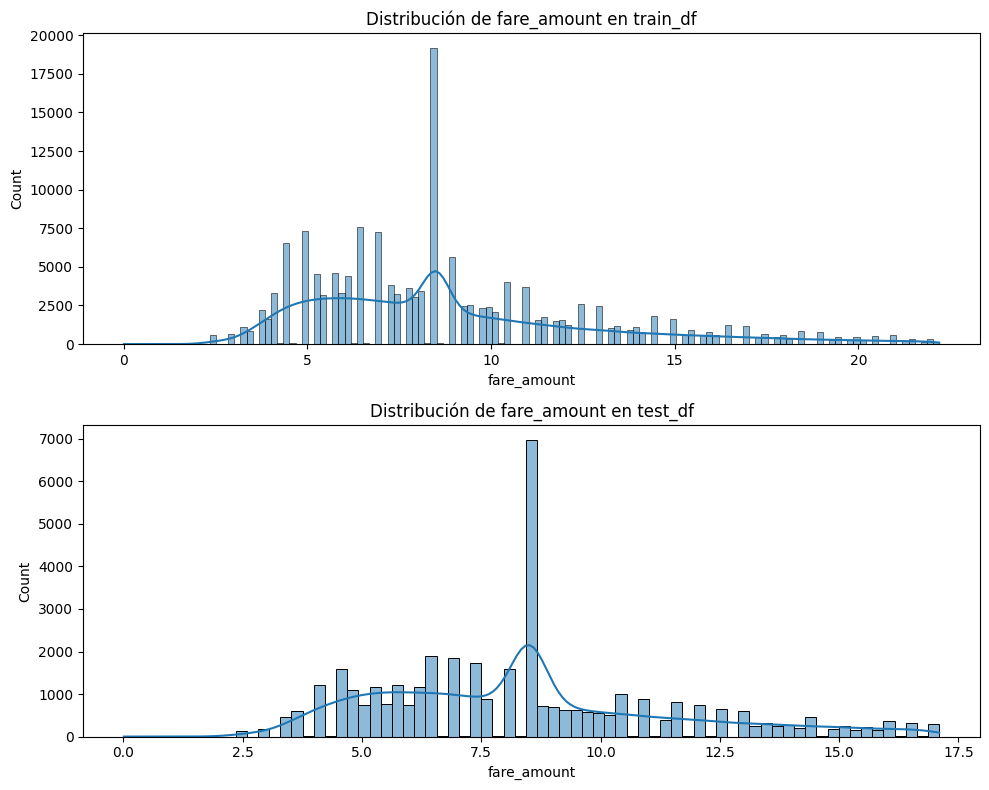

In [ ]:
plt.figure(figsize=(10, 8))

# Histograma para 'fare_amount' en train_df
plt.subplot(2, 1, 1)
sns.histplot(train_df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en train_df")

# Histograma para 'fare_amount' en test_df
plt.subplot(2, 1, 2)
sns.histplot(test_df['fare_amount'], kde=True)
plt.title("Distribución de fare_amount en test_df")

plt.tight_layout()
plt.show()

### Imputacion de Distancia

Elegimos imputar las distancias incorrectas en 'distancia_manhattan_km' utilizando dos enfoques:


*  Imputación de Outliers: Para los valores que superan el límite superior determinado por el IQR, utilizamos el precio por kilómetro promedio. Esto se debe a que los viajes con distancias excesivas pueden ser errores de entrada de datos. Al calcular el precio por kilómetro promedio y ajustar las distancias, mantenemos la coherencia entre la tarifa y la distancia, lo que mejora la calidad de los datos.

Elegimos imputar las distancias incorrectas en 'distancia_manhattan_km' utilizando dos enfoques:


*  Imputación de Distancias Cero: Para las distancias que son cero, utilizamos la mediana de las distancias no outliers..

Límite superior para considerar outliers: 10.191154125002704
Empty DataFrame
Columns: [fare_amount, passenger_count, distancia_manhattan_km, is_holiday, temp_promedio, llovia, year, is_weekend, momento_dia, estacion]
Index: []
Precio por KM:  inf


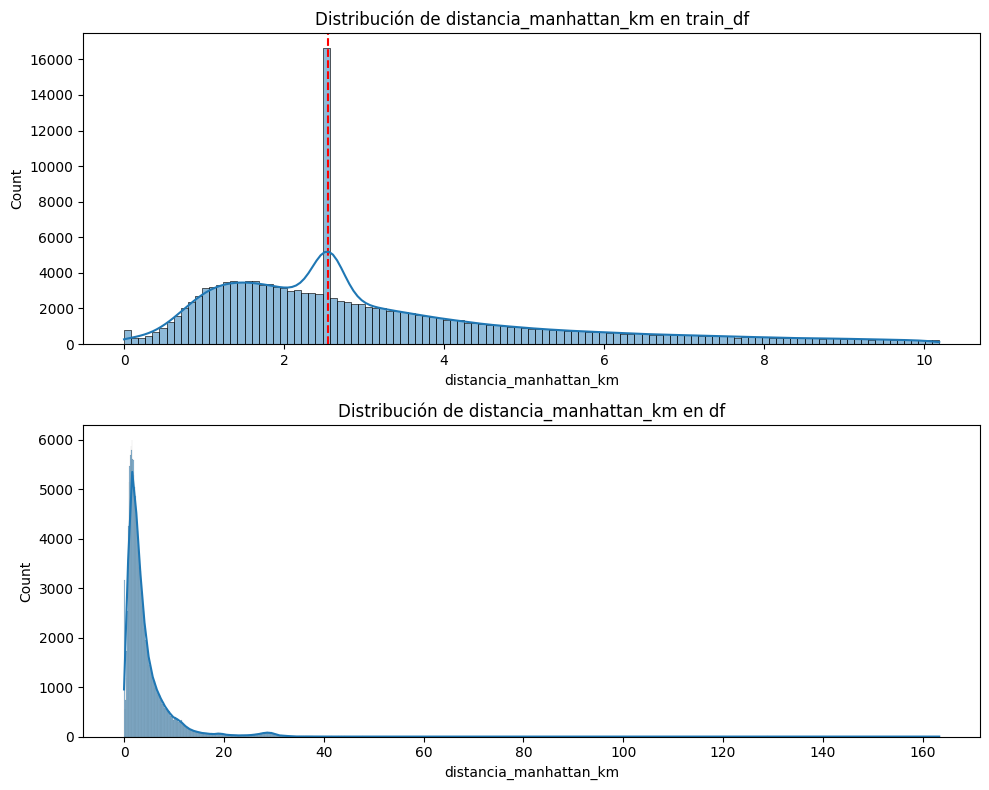

In [ ]:
# Calcular el IQR para la distancia en train_df
Q1 = train_df['distancia_manhattan_km'].quantile(0.25)
Q3 = train_df['distancia_manhattan_km'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
print(f"Límite superior para considerar outliers: {limite_superior}")

# Filtrar los viajes que no son outliers y tienen distancia mayor que cero en train_df
viajes_no_outliers = train_df[(train_df['distancia_manhattan_km'] <= limite_superior) & (train_df['distancia_manhattan_km'] >= 0)]

# Calcular el precio por kilómetro promedio para los viajes no outliers en train_df
precio_por_km_promedio = (viajes_no_outliers['fare_amount'] / viajes_no_outliers['distancia_manhattan_km']).mean()

# Calcular la mediana de las distancias no outliers en train_df
mediana_distancia = viajes_no_outliers['distancia_manhattan_km'].median()

# Imputar distancias incorrectas en train_df usando el precio por kilómetro promedio
train_df_before = train_df.copy()  # Copia para comparación
train_df.loc[train_df['distancia_manhattan_km'] > limite_superior, 'distancia_manhattan_km'] = train_df['fare_amount'] / precio_por_km_promedio

# Imputar distancias que son cero en train_df usando la mediana de las distancias
train_df.loc[train_df['distancia_manhattan_km'] == 0, 'distancia_manhattan_km'] = mediana_distancia

# Verificar el resultado
print(train_df[(train_df['distancia_manhattan_km'] > limite_superior) | (train_df['distancia_manhattan_km'] == 0)])
print("Precio por KM: ", precio_por_km_promedio)


# Calcular las medianas
mediana_train = train_df['distancia_manhattan_km'].median()
mediana_df = df['distancia_manhattan_km'].median()

# Visualizar la distribución después de la imputación
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.axvline(mediana_train, color='r', linestyle='--', label=f'Mediana: {mediana_train:.2f}')
sns.histplot(train_df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en train_df")

plt.subplot(2, 1, 2)
sns.histplot(df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en df")

plt.tight_layout()
plt.show()

Podemos observar que la moda coincide con la mediana debido a la imputacion de valores de distancia que son 0

Límite superior para considerar outliers en test_df: 10.33289149999997
Empty DataFrame
Columns: [fare_amount, passenger_count, distancia_manhattan_km, is_holiday, temp_promedio, llovia, year, is_weekend, momento_dia, estacion]
Index: []
Precio por KM en test_df:  inf


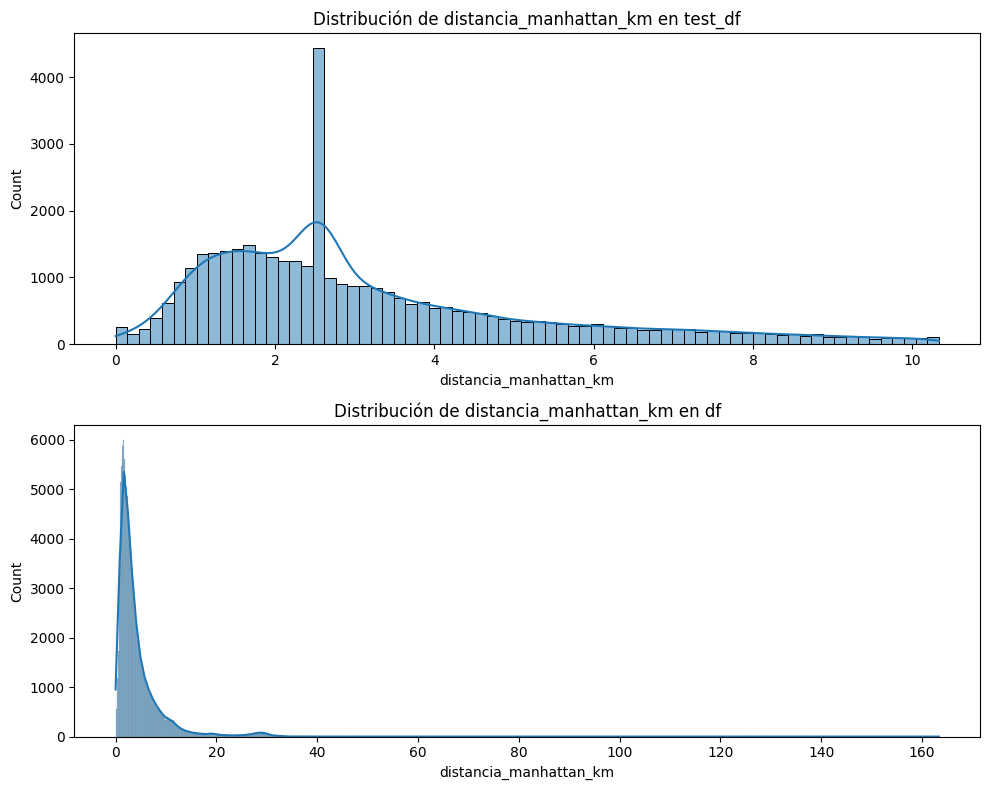

In [ ]:
#TEST

# Calcular el IQR para la distancia en test_df
Q1_test = test_df['distancia_manhattan_km'].quantile(0.25)
Q3_test = test_df['distancia_manhattan_km'].quantile(0.75)
IQR_test = Q3_test - Q1_test

limite_superior_test = Q3_test + 1.5 * IQR_test
print(f"Límite superior para considerar outliers en test_df: {limite_superior_test}")

# Filtrar los viajes que no son outliers y tienen distancia mayor que cero en test_df
viajes_no_outliers_test = test_df[(test_df['distancia_manhattan_km'] <= limite_superior_test) & (test_df['distancia_manhattan_km'] >= 0)]

# Calcular el precio por kilómetro promedio para los viajes no outliers en test_df
precio_por_km_promedio_test = (viajes_no_outliers_test['fare_amount'] / viajes_no_outliers_test['distancia_manhattan_km']).mean()

# Calcular la mediana de las distancias no outliers en test_df
mediana_distancia_test = viajes_no_outliers_test['distancia_manhattan_km'].median()

# Imputar distancias incorrectas en test_df usando el precio por kilómetro promedio
test_df_before = test_df.copy()  # Copia para comparación
test_df.loc[test_df['distancia_manhattan_km'] > limite_superior_test, 'distancia_manhattan_km'] = test_df['fare_amount'] / precio_por_km_promedio_test

# Imputar distancias que son cero en test_df usando la mediana de las distancias
test_df.loc[test_df['distancia_manhattan_km'] == 0, 'distancia_manhattan_km'] = mediana_distancia_test

# Verificar el resultado
print(test_df[(test_df['distancia_manhattan_km'] > limite_superior_test) | (test_df['distancia_manhattan_km'] == 0)])
print("Precio por KM en test_df: ", precio_por_km_promedio_test)

# Visualizar la distribución después de la imputación
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.histplot(test_df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en test_df")

plt.subplot(2, 1, 2)
sns.histplot(df['distancia_manhattan_km'], kde=True)
plt.title("Distribución de distancia_manhattan_km en df")

plt.tight_layout()
plt.show()

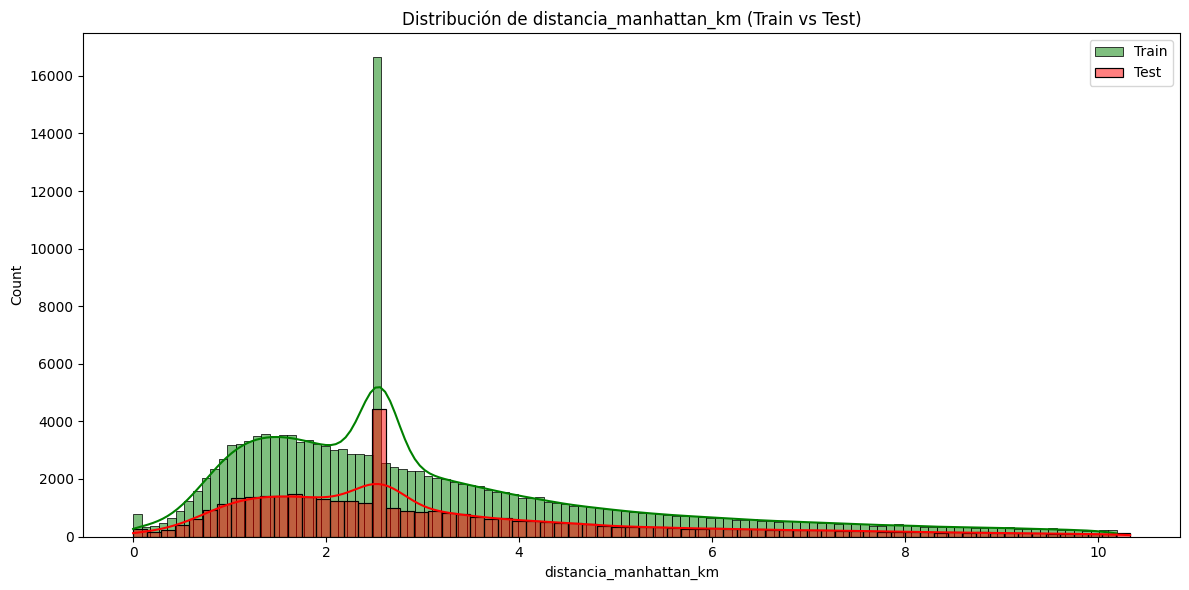

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['distancia_manhattan_km'], kde=True, color='green', label='Train')
sns.histplot(test_df['distancia_manhattan_km'], kde=True, color='red', label='Test')
plt.title("Distribución de distancia_manhattan_km (Train vs Test)")
plt.legend()

plt.tight_layout()
plt.show()

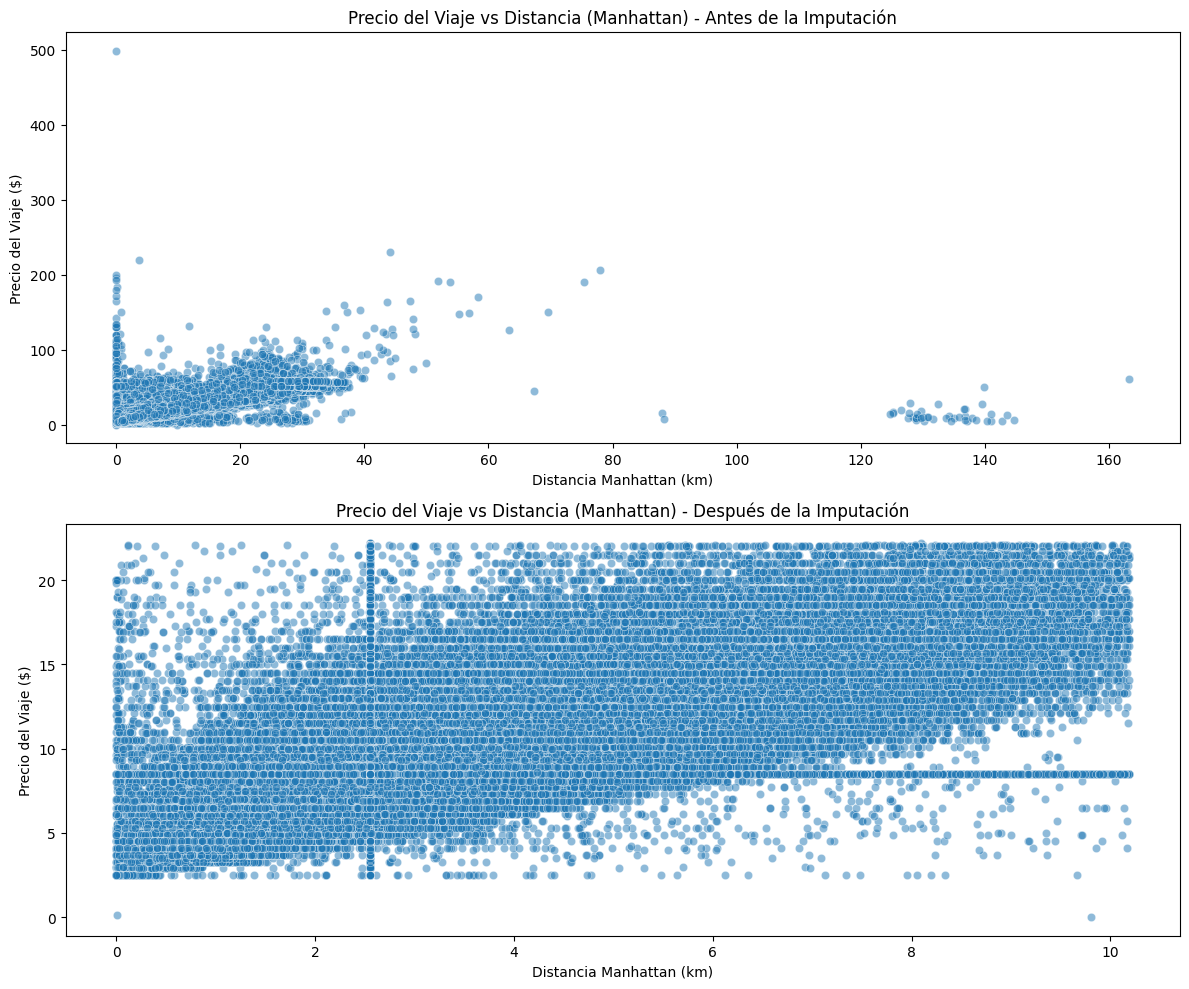

In [ ]:
plt.figure(figsize=(12, 10))

# Gráfico antes de la imputación (usando df)
plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='distancia_manhattan_km', y='fare_amount', alpha=0.5)
plt.title('Precio del Viaje vs Distancia (Manhattan) - Antes de la Imputación')
plt.xlabel('Distancia Manhattan (km)')
plt.ylabel('Precio del Viaje ($)')

# Gráfico después de la imputación (usando train_df)
plt.subplot(2, 1, 2)
sns.scatterplot(data=train_df, x='distancia_manhattan_km', y='fare_amount', alpha=0.5)
plt.title('Precio del Viaje vs Distancia (Manhattan) - Después de la Imputación')
plt.xlabel('Distancia Manhattan (km)')
plt.ylabel('Precio del Viaje ($)')

# Ajustar el layout
plt.tight_layout()
plt.show()

### Separamos las caracteristicas de los conjuntos de train y test

In [ ]:
# Separar las características y la variable objetivo en train_df
X_train = train_df.drop(columns='fare_amount')
y_train = train_df['fare_amount']

# Separar las características y la variable objetivo en test_df
X_test = test_df.drop(columns='fare_amount')
y_test = test_df['fare_amount']

# Verificar las dimensiones
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (156648, 9)
Dimensiones de y_train: (156648,)
Dimensiones de X_test: (39163, 9)
Dimensiones de y_test: (39163,)


# Escalado de los datos

In [ ]:
#Escalado de datos.
scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Modelo de Regresión Lineal:

In [ ]:
#Transformación a arrays de numpy.
X_train_scaled = np.asarray(X_train_scaled)
y_train = np.asarray(y_train).reshape(-1, 1)
X_test_scaled = np.asarray(X_test_scaled)
y_test = np.asarray(y_test).reshape(-1, 1)

y_train = np.asarray(y_train).ravel()
y_test = np.asarray(y_test).ravel()

In [ ]:
model = LinearRegression()

In [ ]:
# Aplicar cross-validation en el conjunto de entrenamiento
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation MSE Scores:", -cv_scores)
print("Mean MSE:", -cv_scores.mean())

Cross-Validation MSE Scores: [7.88606319 7.95237209 7.94448356 7.63735374 7.78237974]
Mean MSE: 7.84053046494559


Los resultados de la validación cruzada muestran que el modelo de regresión lineal tiene un error cuadrático medio (MSE) promedio de aproximadamente 7.84. Esto indica que, en promedio, las predicciones del modelo se desvían del valor real en una magnitud que, al cuadrado, es 7.84. Los puntajes individuales de MSE para cada fold son bastante consistentes, oscilando entre 7.64 y 7.95, lo que sugiere que el modelo tiene un rendimiento estable y no está sobreajustado a un subconjunto específico de los datos de entrenamiento.

In [ ]:
# Ajustar el modelo
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [ ]:
# Test metrics
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)

print(f"R2 Score Test: {r2_test}")
print(f"MSE Test: {mse_test}")
print(f"RMSE Test: {rmse_test}")

# Train metrics
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print("-------------------------")
print(f"R2 Score Train: {r2_train}")
print(f"MSE Train: {mse_train}")
print(f"RMSE Train: {rmse_train}")


R2 Score Test: 0.3103875130977939
MSE Test: 6.677084684001378
RMSE Test: 2.584005550303903
-------------------------
R2 Score Train: 0.4993071668051192
MSE Train: 7.83938047535731
RMSE Train: 2.799889368413922


TEST

R² Score (0.3104): El modelo de regresión lineal explica solo el 31.04% de la variabilidad en los precios de los viajes de Uber. Esto sugiere que hay otros factores importantes que afectan el costo del viaje y que no están incluidos en el modelo.

MSE (6.6771): El error cuadrático medio indica que, en promedio, el cuadrado de las diferencias entre los precios predichos y los reales es 6.6771 dólares. Esto refleja un ajuste moderado del modelo a los datos.

RMSE (2.5840): Las predicciones del modelo están, en promedio, a 2.5840 dólares de los precios reales de los viajes. Este error en dólares sugiere que las predicciones pueden no ser muy precisas.



In [ ]:
print("Varianza y_train:", np.var(y_train))
print("Varianza y_test:", np.var(y_test))


Varianza y_train: 15.657065481314868
Varianza y_test: 9.682372072459668


Resulta exraño que el mse de mas alto en train que en test pero se puede explicar por la varianza de los conjuntes de train y test

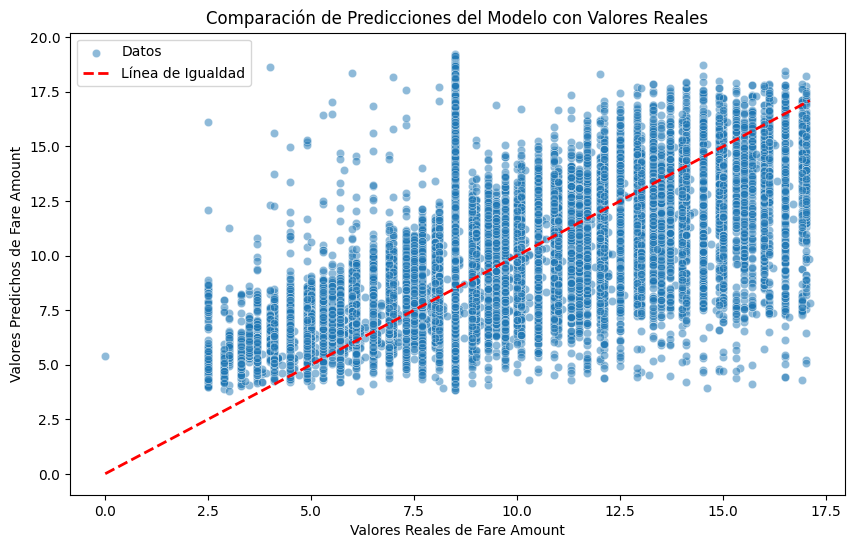

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label='Datos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea de Igualdad')
plt.xlabel('Valores Reales de Fare Amount')
plt.ylabel('Valores Predichos de Fare Amount')
plt.title('Comparación de Predicciones del Modelo con Valores Reales')
plt.legend()
plt.show()

Podemos observar que las predicciones del modelo no se alinean perfectamente con los valores reales, lo que indica un error significativo en las predicciones. La dispersión de los puntos sugiere que el modelo no está capturando completamente la relación entre las variables.

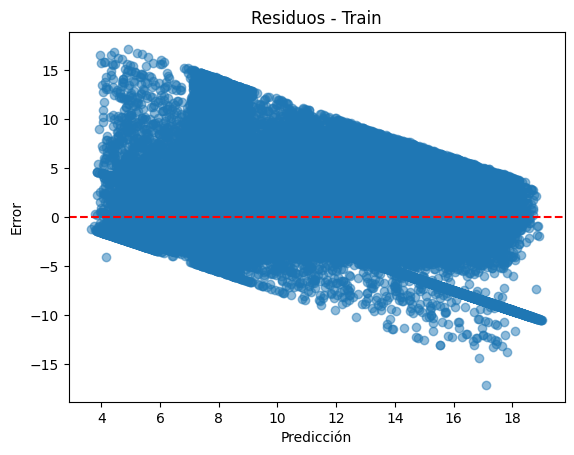

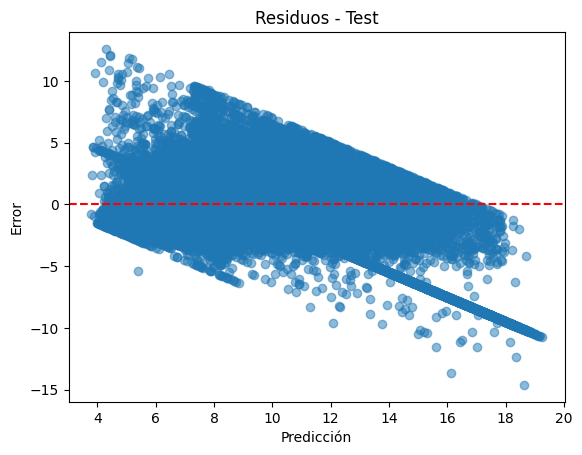

In [ ]:
# Train
residuals_train = y_train - y_train_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuos - Train")
plt.xlabel("Predicción")
plt.ylabel("Error")
plt.show()

# Test
residuals_test = y_test - y_pred
plt.scatter(y_pred, residuals_test, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuos - Test")
plt.xlabel("Predicción")
plt.ylabel("Error")
plt.show()

Observamos un patrón en los residuos, lo que sugiere que el modelo podría no estar capturando adecuadamente la relación entre las variables. Esto podría indicar la presencia de heterocedasticidad o una relación no lineal.

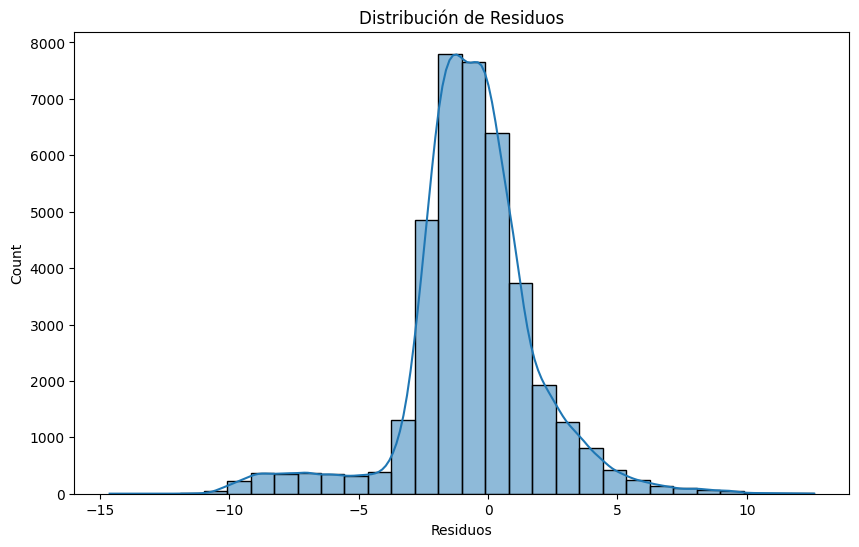

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()

La distribución de los residuos no es perfectamente normal, lo que podría afectar la validez de las inferencias del modelo.

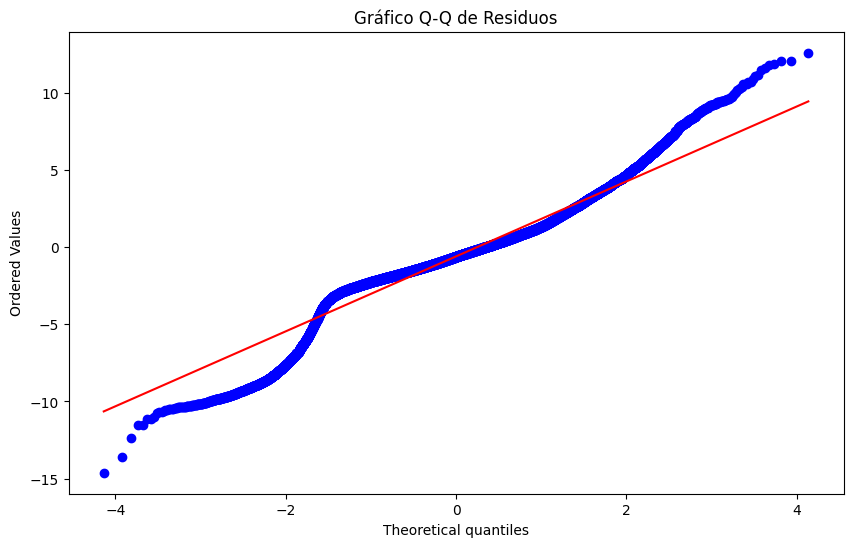

In [ ]:
plt.figure(figsize=(10, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de Residuos')
plt.show()

Los residuos muestran desviaciones de la normalidad, especialmente en los extremos. Esto refuerza la necesidad de considerar ajustes en el modelo o transformacione.

#Gradiente Descendiente:

In [ ]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    print(f"RMSE de entrenamiento final: {np.sqrt(train_errors[-1])}")
    print(f"RMSE de prueba final: {np.sqrt(test_errors[-1])}")

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=10, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    print(f"RMSE de entrenamiento final: {np.sqrt(train_errors[-1])}")
    print(f"RMSE de prueba final: {np.sqrt(test_errors[-1])}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [ ]:
gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.1, epochs=100)
#gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.1, epochs=1000)
#gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=100)
#gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=100)

In [ ]:
X_test_bias = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

y_pred_test = np.matmul(X_test_bias, grad)
r2 = r2_score(y_test, y_pred_test)
print(f"Gradient_descent.R²: {r2}")

In [ ]:
mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=10000)
#mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=100)
#mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=100000)
#mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.0001, epochs=100, batch_size=10000)
#mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.1, epochs=100, batch_size=10000)

In [ ]:
X_test_bias = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

y_pred_test = np.matmul(X_test_bias, mini_grad)
r2 = r2_score(y_test, y_pred_test)
print(f"Mini_batch_gradient_descent.R²: {r2}")

#Regularización:

### Ridge Regression

In [ ]:
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return r2, mse, rmse, mae, mape

Mejores hiperparámetros Ridge: {'alpha': 10.0}
Ridge Metrics: R2=0.3104198002377303, MSE=6.676772067899359, RMSE=2.5839450589939714


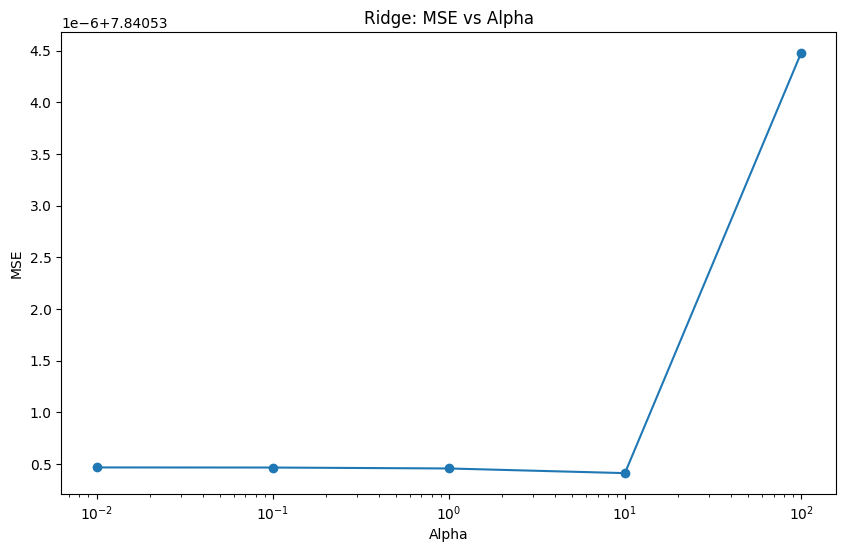

In [ ]:
# Definir el modelo Ridge
ridge = Ridge()

# Establecer el espacio de hiperparámetros para Ridge
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Configurar GridSearchCV para Ridge
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, scoring='neg_mean_squared_error', cv=5)

# Ajustar el modelo Ridge
grid_search_ridge.fit(X_train_scaled, y_train)

# Obtener el mejor modelo Ridge
best_ridge = grid_search_ridge.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo Ridge
y_pred_ridge = best_ridge.predict(X_test_scaled)

# Calcular e imprimir las métricas para Ridge
ridge_metrics = calculate_metrics(y_test, y_pred_ridge)
print("Mejores hiperparámetros Ridge:", grid_search_ridge.best_params_)
print(f"Ridge Metrics: R2={ridge_metrics[0]}, MSE={ridge_metrics[1]}, RMSE={ridge_metrics[2]}")

# Graficar el MSE según el alpha
results_ridge = grid_search_ridge.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(param_grid_ridge['alpha'], -results_ridge['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge: MSE vs Alpha')
plt.show()



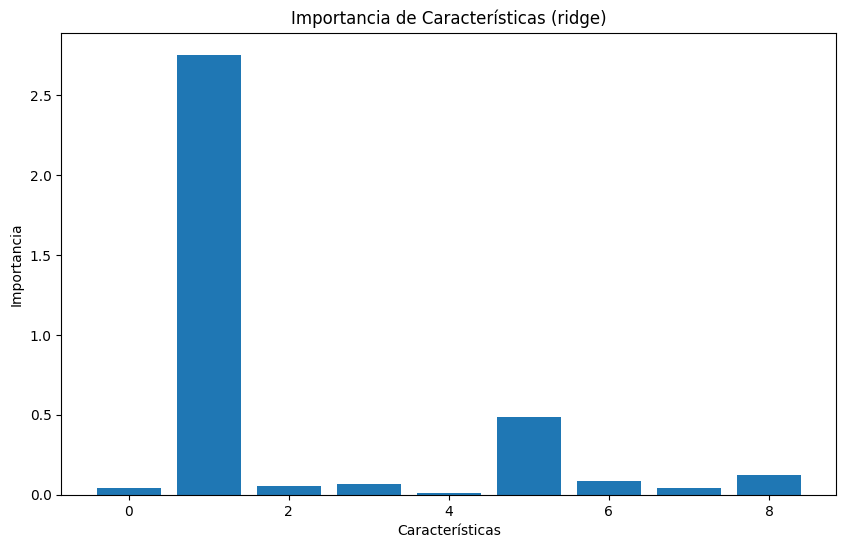

In [ ]:
feature_importance = np.abs(best_ridge.coef_)
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características (ridge)')
plt.show()

### Lasso Regression

Mejores hiperparámetros Lasso: {'alpha': 0.01}
Lasso Metrics: R2=0.3126384830721486, MSE=6.655289955185741, RMSE=2.5797848660664986


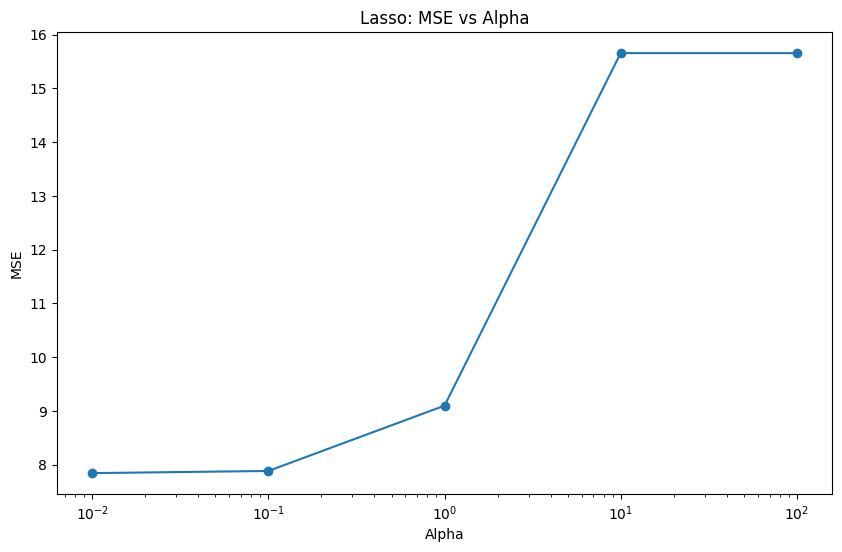

In [ ]:
# Definir el modelo Lasso
lasso = Lasso()

# Establecer el espacio de hiperparámetros para Lasso
param_grid_lasso = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Configurar GridSearchCV para Lasso
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

# Ajustar el modelo Lasso
grid_search_lasso.fit(X_train_scaled, y_train)

# Obtener el mejor modelo Lasso
best_lasso = grid_search_lasso.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo Lasso
y_pred_lasso = best_lasso.predict(X_test_scaled)

# Calcular e imprimir las métricas para Lasso
lasso_metrics = calculate_metrics(y_test, y_pred_lasso)
print("Mejores hiperparámetros Lasso:", grid_search_lasso.best_params_)
print(f"Lasso Metrics: R2={lasso_metrics[0]}, MSE={lasso_metrics[1]}, RMSE={lasso_metrics[2]}")

# Graficar el MSE según el alpha
results_lasso = grid_search_lasso.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(param_grid_lasso['alpha'], -results_lasso['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso: MSE vs Alpha')
plt.show()

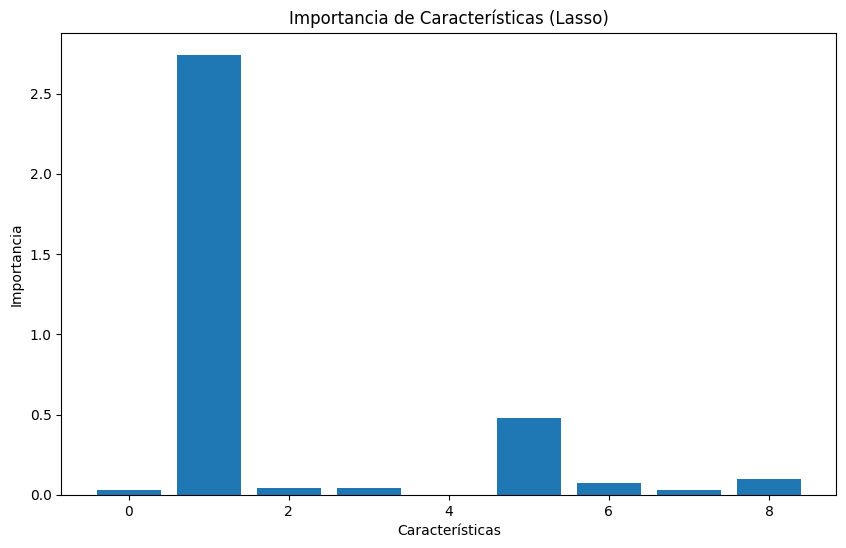

In [ ]:
feature_importance = np.abs(best_lasso.coef_)
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características (Lasso)')
plt.show()

### Elastic Net

Mejores hiperparámetros Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.1}
Elastic Net Metrics: R2=0.3150569267787259, MSE=6.631873683382363, RMSE=2.575242451378581


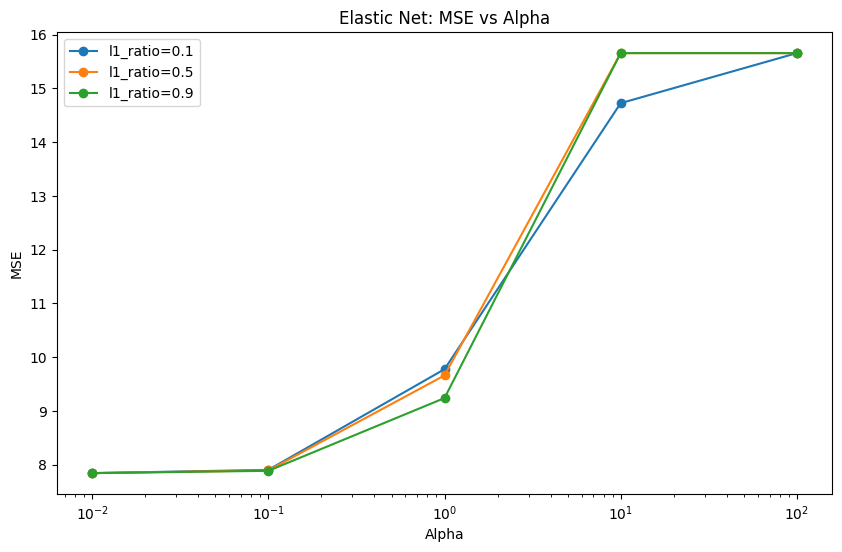

In [ ]:
# Definir el modelo Elastic Net
elastic_net = ElasticNet()

# Establecer el espacio de hiperparámetros para Elastic Net
param_grid_elastic = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.5, 0.9]}

# Configurar GridSearchCV para Elastic Net
grid_search_elastic = GridSearchCV(estimator=elastic_net, param_grid=param_grid_elastic, scoring='neg_mean_squared_error', cv=5)

# Ajustar el modelo Elastic Net
grid_search_elastic.fit(X_train_scaled, y_train)

# Obtener el mejor modelo Elastic Net
best_elastic = grid_search_elastic.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo Elastic Net
y_pred_elastic = best_elastic.predict(X_test_scaled)

# Calcular e imprimir las métricas para Elastic Net
elastic_metrics = calculate_metrics(y_test, y_pred_elastic)
print("Mejores hiperparámetros Elastic Net:", grid_search_elastic.best_params_)
print(f"Elastic Net Metrics: R2={elastic_metrics[0]}, MSE={elastic_metrics[1]}, RMSE={elastic_metrics[2]}")

# Graficar el MSE según el alpha
results_elastic = grid_search_elastic.cv_results_
plt.figure(figsize=(10, 6))
for l1_ratio in param_grid_elastic['l1_ratio']:
    mask = results_elastic['param_l1_ratio'] == l1_ratio
    plt.plot(param_grid_elastic['alpha'], -results_elastic['mean_test_score'][mask], marker='o', label=f'l1_ratio={l1_ratio}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Elastic Net: MSE vs Alpha')
plt.legend()
plt.show()

alpha = 0.01: regularización muy leve

l1_ratio = 0.1: se usó un 90% de Ridge (L2) y 10% de Lasso (L1)
Es decir, casi todo el poder de regularización vino de Ridge, y solo un poco de Lasso.



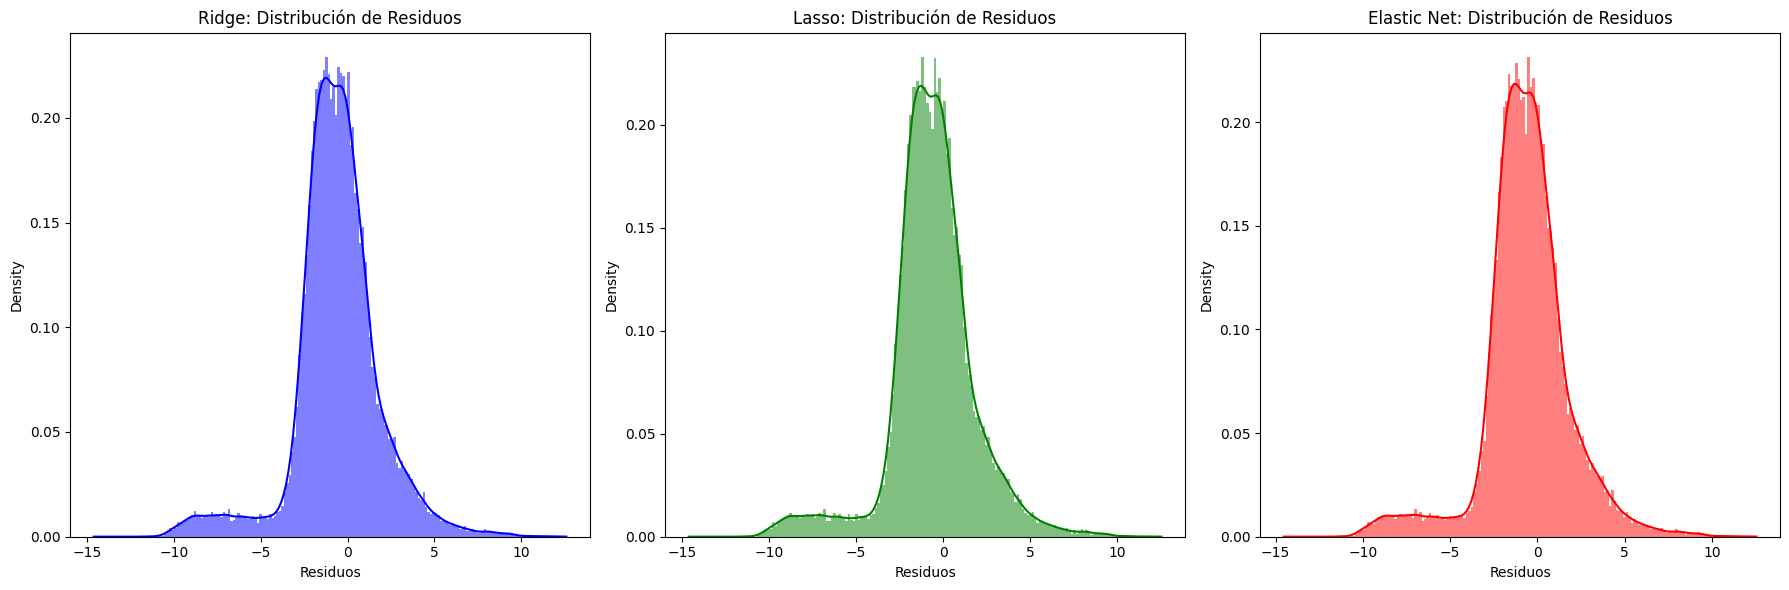

In [ ]:
residuos_ridge = y_test - y_pred_ridge
residuos_lasso = y_test - y_pred_lasso
residuos_elastic = y_test - y_pred_elastic

plt.figure(figsize=(18, 6))

# Subplot para Ridge
plt.subplot(1, 3, 1)
sns.histplot(residuos_ridge, color='blue', kde=True, stat="density", linewidth=0)
plt.xlabel('Residuos')
plt.title('Ridge: Distribución de Residuos')

# Subplot para Lasso
plt.subplot(1, 3, 2)
sns.histplot(residuos_lasso, color='green', kde=True, stat="density", linewidth=0)
plt.xlabel('Residuos')
plt.title('Lasso: Distribución de Residuos')

# Subplot para Elastic Net
plt.subplot(1, 3, 3)
sns.histplot(residuos_elastic, color='red', kde=True, stat="density", linewidth=0)
plt.xlabel('Residuos')
plt.title('Elastic Net: Distribución de Residuos')

plt.tight_layout()
plt.show()

Todos los modelos muestran una distribución de residuos adecuada, centrada alrededor de cero, lo que indica un buen ajuste.

# Conclusiones

## Regresion Lineal Simple

*   **Distribución de Predicciones**: Al comparar la distribución de los valores reales y los predichos, observamos que, aunque hay cierta superposición, las predicciones tienden a estar más concentradas en un rango inferior. Esto sugiere que el modelo podría estar subestimando algunas tarifas más altas.

*   **Métricas de Rendimiento**: El R² en el conjunto de prueba fue de aproximadamente 0.31, lo que indica que
el modelo explica alrededor del 31% de la variabilidad en los datos. Esto sugiere que hay espacio para mejorar el modelo, ya que una mayor proporción de la variabilidad no está siendo capturada.

  El MSE y RMSE en el conjunto de prueba fueron de 6.68 y 2.58, respectivamente. Estos valores indican que, aunque el modelo tiene un rendimiento aceptable, aún hay errores significativos en las predicciones.

  Es interesante notar que el MSE es más alto en el conjunto de entrenamiento que en el de prueba, lo que puede parecer contradictorio a primera vista. Sin embargo, esto se puede explicar por la varianza de los conjuntos de entrenamiento y prueba. La variabilidad en los datos de entrenamiento puede ser mayor, lo que lleva a un ajuste más complejo del modelo, mientras que el conjunto de prueba, al ser más homogéneo, puede resultar en un MSE más bajo.




*   **Predicciones del Modelo**: Al observar las predicciones del modelo, notamos que no se alinean perfectamente con los valores reales, lo que indica un error significativo en las predicciones. La dispersión de los puntos en el gráfico de comparación sugiere que el modelo no está capturando completamente la relación entre las variables, lo que podría ser un indicativo de que se requieren ajustes adicionales o la inclusión de variables que puedan mejorar la precisión del modelo.

*   **Análisis de Residuos**: identificado un patrón en los residuos, lo que sugiere que el modelo podría no estar capturando adecuadamente la relación entre las variables. Esto podría indicar la presencia de heterocedasticidad o una relación no lineal que no se está abordando adecuadamente en el modelo actual. La distribución de los residuos también muestra desviaciones de la normalidad, lo que podría afectar la validez de las inferencias realizadas a partir del modelo.



*   **Desviaciones Notables**: Luego de graficar para combrobar normalidad, los residuos presentan desviaciones notables, especialmente en los extremos, lo que refuerza la necesidad de considerar ajustes en el modelo o transformaciones que puedan ayudar a mejorar su rendimiento y la precisión de las predicciones.


##Gradiente descendente



*   Grandiente Descendente: Cuando aplicamos el método de gradiente descendente,este enfoque utiliza la totalidad del conjunto de entrenamiento en cada iteración para calcular el gradiente, lo que proporciona una convergencia estable y precisa hacia el mínimo de la función de pérdida. El modelo alcanzó un RMSE de 2.58 y un R² de 0.31 en el conjunto de prueba, igualando los resultados obtenidos mediante la solución analítica. Esto confirma que el algoritmo fue capaz de encontrar una solución óptima sin pérdida de precisión. Probamos con diferentes lr, al aumnentarlo en la grafica vemos que la curva diverge mucho, y el RSME aumenta muchisimo, al disminuirlo en la grafica, la curva se termian convirtiendo en recta y no tiene sentido. Con las epocas, si aumentamos mucho puede llegar a un sobreajuste y si son pocas puede no llegar a aprender bien.

*   Mini-Batch: Cuando aplicamos el método Mini-batch, el cual consiste en dividir el conjunto de entrenamiento en pequeños lotes para actualizar los parámetros de manera parcial y más frecuente. Este método permite acelerar el entrenamiento y reducir el uso de memoria, especialmente en datasets grandes.
Al igual que el método anterior, el modelo entrenado con mini-batches alcanzó un RMSE de 2.58 y un R² de 0.31 en el conjunto de prueba. Esto indica que Mini-Batch Gradient Descent logró converger correctamente hacia una solución igualmente precisa. En cuestion de batch_size, si usamos el tamaño total de los datos va a ser similar a Gradient Descent y si el tamaño es igual a 1, es Stochastic Gradient Descent puro. Vemos que usando un tamaño medio, obtenemos un buen resultado.

## Regularizacion

*   **Ridge Regression**: El modelo Ridge, con un mejor hiperparámetro de alpha de 10.0, logró un R² de aproximadamente 0.3104, lo que indica que solo un 31.04% de la variabilidad en los datos es explicada por el modelo. El MSE y RMSE fueron de 6.6768 y 2.5839, respectivamente. Aunque la regularización ayudo a controlar el sobreajuste, el rendimiento general del modelo sigue siendo limitado. La gráfica de MSE en función de alpha muestra que el modelo es sensible a valores altos de alpha, lo que puede llevar a un subajuste.

*   **Lasso Regression**: El modelo Lasso, con un mejor hiperparámetro de alpha de 0.01, presentó un rendimiento ligeramente superior al de Ridge, con un R² de aproximadamente 0.3126 y un MSE de 6.6553. Esto sugiere que Lasso logró una ligera mejora en la capacidad predictiva, posiblemente debido a su capacidad para realizar selección de características, eliminando aquellas que no son relevantes. La gráfica de MSE también indica que el modelo se comporta de manera más estable en un rango más amplio de valores de alpha.

*   **Elastic Net**: El modelo Elastic Net, que combina las penalizaciones de Ridge y Lasso, mostró el mejor rendimiento entre los tres, con un mejor ajuste de hiperparámetros de alpha de 0.01 y un l1_ratio de 0.1. El R² alcanzó aproximadamente 0.3151, y el MSE fue de 6.6319, lo que indica que este modelo es el más efectivo en la captura de la variabilidad en los datos. La gráfica de MSE sugiere que Elastic Net se beneficia de la flexibilidad que ofrece al ajustar tanto la regularización L1 como L2.

  l1_ratio = 0.1: se usó un 90% de Ridge (L2) y 10% de Lasso (L1) Es decir, casi todo el poder de regularización vino de Ridge, y solo un poco de Lasso.

*   **Comparación de Hiperparámetros**: Los hiperparámetros elegidos para cada modelo reflejan sus diferentes enfoques. Ridge utilizó un alpha más alto, lo que indica una mayor penalización para evitar el sobreajuste, mientras que Lasso optó por un alpha más bajo, permitiendo una mayor flexibilidad en la selección de características. Elastic Net, al combinar ambos enfoques, logró un equilibrio que resultó en un mejor rendimiento general.

*   **Conclusión General**: En resumen, aunque todos los modelos presentaron un rendimiento similar en términos de R², Elastic Net demostró ser el más efectivo en la predicción del monto de la tarifa. La elección de hiperparámetros fue crucial para cada modelo, y su análisis sugiere que la combinación de regularización L1 y L2 puede ofrecer ventajas significativas en la captura de la complejidad de los datos. Sin embargo, todos los modelos aún presentan un margen considerable de mejora, lo que sugiere que se podrían explorar enfoques adicionales o transformaciones de características para optimizar aún más la capacidad predictiva.

